# Variational AutoEncoder - MNIST


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab_Notebooks/ERA2-Session-21-unet

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/ERA2-Session-21-unet


## Install Dependencies

In [2]:
! pip install pytorch-lightning --quiet
! pip install lightning-bolts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 16.1 MB/s eta 0:00:00


## Import Modules

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelSummary

## DataLoader

In [4]:
BATCH_SIZE = 32

normalize_data = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                     ])

train_dataset = MNIST(root='./data', train=True, transform=normalize_data, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MNIST(root='./data', train=False, transform=normalize_data, download=True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16288729.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 517295.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4557024.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3899801.18it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
print(f"Images Shape: {next(iter(train_dataloader))[0].shape}    Labels Shape: {next(iter(train_dataloader))[1].shape}")

Images Shape: torch.Size([32, 1, 28, 28])    Labels Shape: torch.Size([32])


## Model Architecture

In [6]:
class VAE(pl.LightningModule):
    """
    Lightning Module for VAE
    """
    def __init__(self, enc_out_dim=256, latent_dim=256, input_height=28):
        """
        Constructor
        """
        # Initialize the lightning module
        super().__init__()

        # Save the input params
        self.save_hyperparameters()

        # Encoder Layers
        self.encoder_conv_layers = nn.Sequential(
            self.conv_layer(in_channels=2, out_channels=32),             # Input Channels = 4  [2 for Grayscale and 1 for label data]
            self.conv_layer(in_channels=32, out_channels=64),
            self.conv_layer(in_channels=64, out_channels=128),
            self.conv_layer(in_channels=128, out_channels=256)
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim * 20 * 20, latent_dim)        # 20 since input image size is reduced to 20 after 3 conv layers
        self.fc_var = nn.Linear(enc_out_dim * 20 * 20, latent_dim)

        # Decoder's Linear Layer
        self.linear = nn.Linear(latent_dim + 10, enc_out_dim * 20 * 20)  # 10 [One for each class]

        # Decoder Layers
        self.decoder_conv_layers = nn.Sequential(
            self.transpose_layer(in_channels=256, out_channels=128),
            nn.ReLU(),
            self.transpose_layer(in_channels=128, out_channels=64),
            nn.ReLU(),
            self.transpose_layer(in_channels=64, out_channels=32),
            nn.ReLU(),
            self.transpose_layer(in_channels=32, out_channels=1)
        )

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def conv_layer(self, in_channels, out_channels):
        """
        Function to return conv layer
        """
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, bias=False),
            nn.ReLU()
        )

    def transpose_layer(self, in_channels, out_channels):
        """
        Function to return Transpose layer
        """
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, bias=False)
        )

    def encoder(self, x, y):
        """
        Encoder Block of the VAE
        """
        # Batch size and input dimensions
        batch_size = x.shape[0]
        img_height = x.shape[2]   # Height = Width

        # Concatenate Label data to the image data
        y = torch.argmax(y, dim=1).reshape((y.shape[0], 1, 1, 1))
        y = torch.ones(x.shape).to(self.device) * y
        concat_input = torch.cat((x, y), dim=1)

        # Pass the concatenated input through the encoder layers and flatten it
        x = self.encoder_conv_layers(concat_input)
        x = x.view(batch_size, -1)
        return x

    def decoder(self, z, y):
        """
        Decoder Block of VAE
        """
        # Add 10 neurons (one for each class to the latent layer)
        z = torch.cat((z, y.float()), dim=1)

        # Latent layer
        x_hat = F.relu(self.linear(z))
        x_hat = x_hat.reshape(-1, 256, 20, 20)

        # Decoder layers
        x_hat = self.decoder_conv_layers(x_hat)
        x_hat = torch.sigmoid(x_hat)
        return x_hat

    def configure_optimizers(self):
        """
        Optimizer for model training
        """
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        """
        """
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        """
        """
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def forward(self, x, y):
        """
        Forward method
        """
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x, y)

        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        x_hat = self.decoder(z, y)
        return x_hat

    def training_step(self, batch, batch_idx):
        """
        Function to train the model
        """
        # Input data
        x, y = batch

        # One-Hot encoding of label data
        y = F.one_hot(y, num_classes=10)

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x, y)

        # Encoder output mu and sigma
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z, y)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

## Model Training

In [7]:
# Seed for deterministic results
pl.seed_everything(8)

# Instance of the model
model = VAE()

# Trainer configuration
trainer = pl.Trainer(
    callbacks=[ModelSummary(max_depth=1)],
    gpus=1,
    num_sanity_val_steps=1,
    max_epochs=10
    )

# Train the model
trainer.fit(model, train_dataloader, test_dataloader)

INFO:lightning_fabric.utilities.seed:Global seed set to 8
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: Us

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Model Output

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure
import numpy as np


def vae_results(x, y, model, classes, correct_labels=True, num_outputs=25):
    """
    Function to display output images generated by the model
    """
    # Figure to display the results
    figure(figsize=(8, 3), dpi=300)
    device = model.device

    # Set the model to eval mode
    with torch.no_grad():
        # Change the value to get incorrect label values
        y_incorrect = y - 1                   # Reduce class value by 1
        y_incorrect[y_incorrect == -1] = 9    # Change -1 to 9

        # One-Hot Encoding
        one_hot_y = F.one_hot(y, num_classes=10)
        one_hot_incorrect_y = F.one_hot(y_incorrect, num_classes=10)

        # Send correct labels to Encoder based on function argument
        if correct_labels:
            x_encoded = model.encoder(x.to(device), one_hot_y.to(device))
        else:
            x_encoded = model.encoder(x.to(device), one_hot_incorrect_y.to(device))

        # Get mean and variance from encoder output
        mu, log_var = model.fc_mu(x_encoded), model.fc_var(x_encoded)

        # Calculate standard deviation
        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        # Send correct labels to Decoder based on function argument
        if correct_labels:
            x_hat = model.decoder(z, one_hot_y.to(device))
        else:
            x_hat = model.decoder(z, one_hot_incorrect_y.to(device))

        # Plot Results
        fig = plt.figure(figsize=(10, 10))
        for index in np.arange(num_outputs):
            axs = fig.add_subplot(5, 5, index + 1, xticks=[], yticks=[])
            img = x_hat[index].to('cpu')
            plt.imshow(img.permute(1, 2, 0), cmap='gray')

            if correct_labels:
                axs.set_title(f"Label: {classes[y[index]]}")
            else:
                axs.set_title(f"Incorrect Label: {classes[y_incorrect[index]]}\n Correct Label: {classes[y[index]]}")

        fig.tight_layout()
        plt.show()

### Output with Correct Labels

<Figure size 2400x900 with 0 Axes>

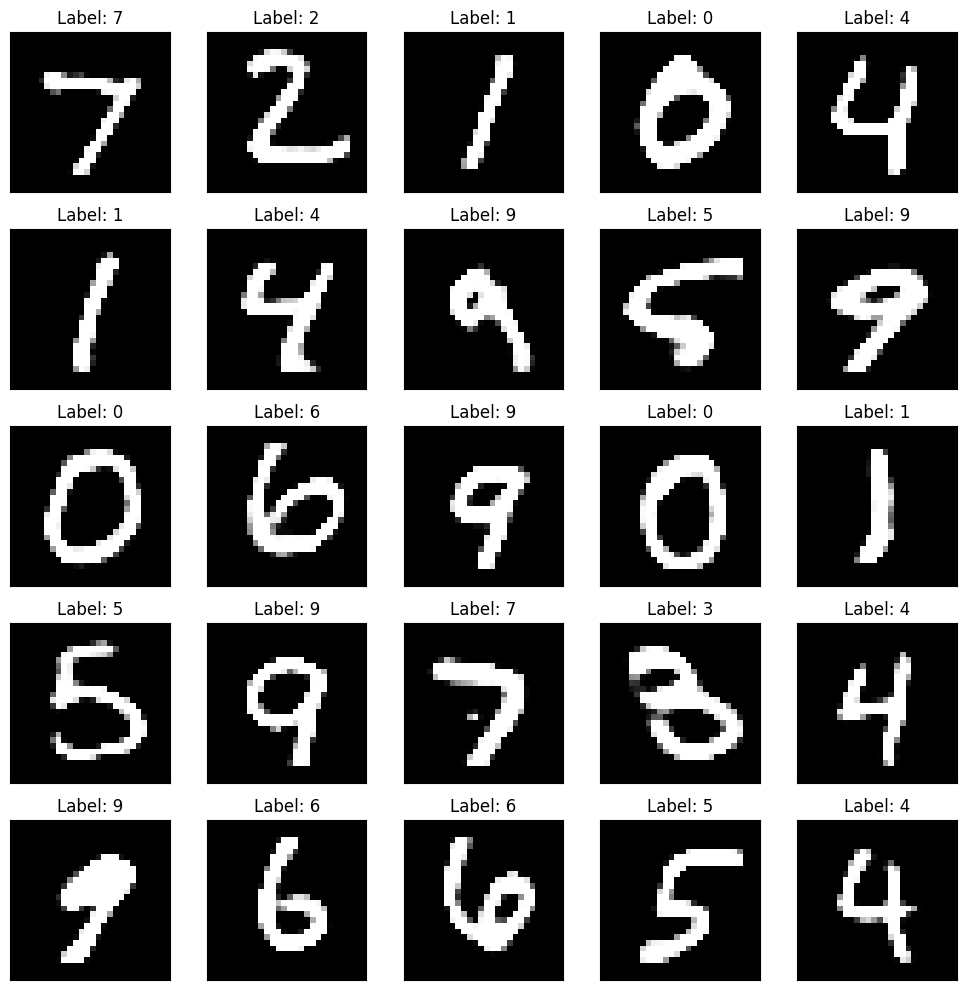

In [9]:
classes = list(range(0, 10))
x, y = next(iter(test_dataloader))
vae_results(x, y, model, classes)

### Output with Incorrect Labels

<Figure size 2400x900 with 0 Axes>

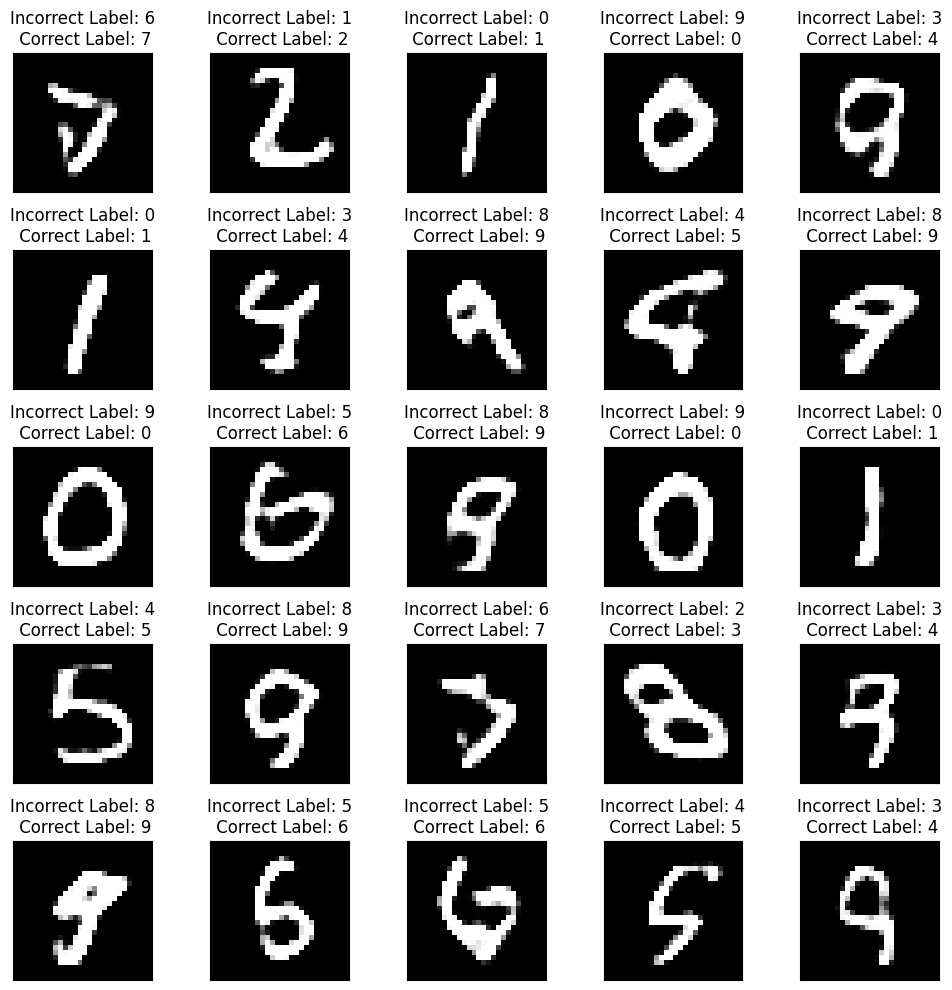

In [10]:
vae_results(x, y, model, classes, correct_labels=False)

### Output with correct Labels

<Figure size 2400x900 with 0 Axes>

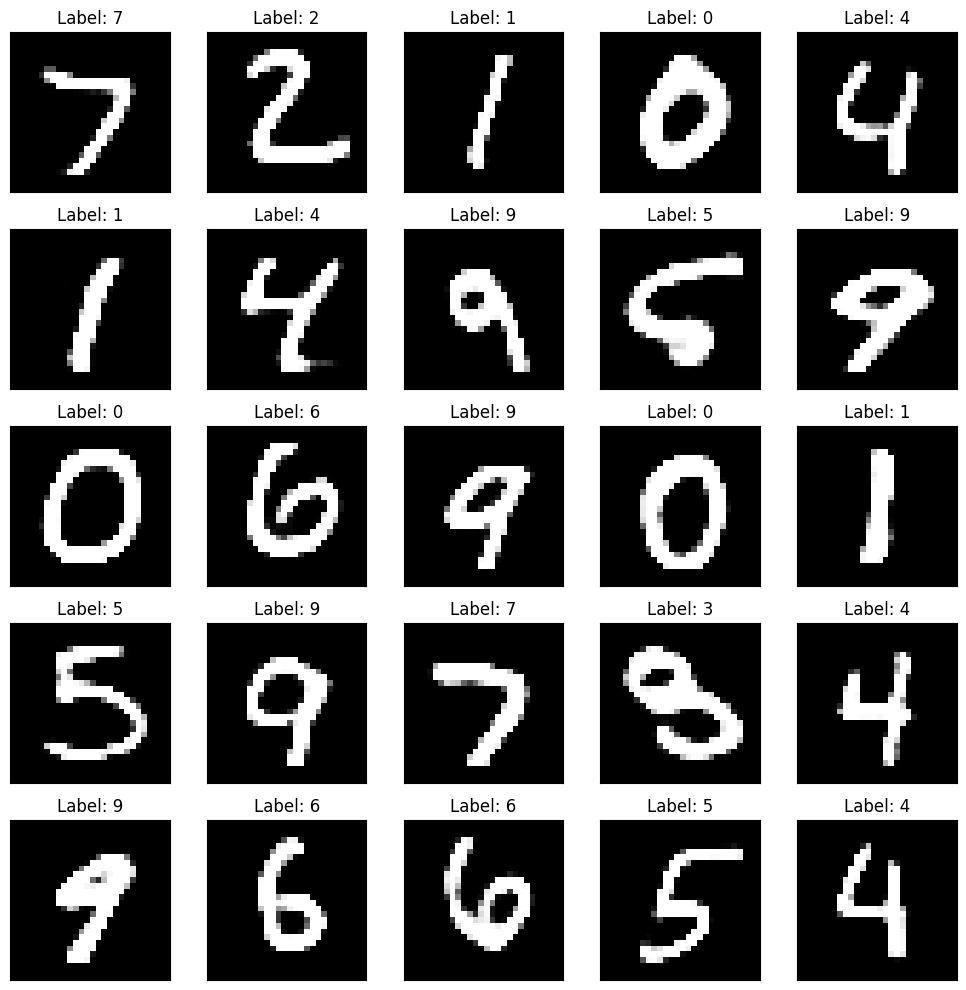

In [14]:
vae_results(x, y, model, classes, correct_labels=True)

In [15]:
torch.save(model.state_dict(), 'vae_model.pth')